# Evaluating Model Performance
We will evaluate and compare the performance of the models using the following metrics:
- Accuracy
- Precision
- Recall


In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, top_k_accuracy_score, f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
import itertools
import numpy as np
import pandas as pd

In [2]:
# os.chdir(r'C:\Users\david\projects\University\gemstone-classifier\src')
curr_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(curr_dir, os.pardir))


### Load the training results

In [3]:
results = {}
top_results = pd.DataFrame(columns=['Model', 'Dataset', 'Accuracy', 'Top-3 Accuracy', 'Top-5 Accuracy'])

for dataset in os.listdir('../mod/'):
    for file in os.listdir(f'../mod/{dataset}/'):
        if file.endswith('.csv'):
            model = os.path.splitext(file)[0]
            print(f'Processing {model}...')
            history = pd.read_csv(f'../mod/{dataset}/{file}')
            results[model + ' ' + dataset] = history
            top_results = pd.concat([top_results, pd.DataFrame({'Model': model,
                                                                'Dataset': dataset,
                                                                'Accuracy': history['val_accuracy'].max(),
                                                                'Top-3 Accuracy': history['val_top_3_accuracy'].max(),
                                                                'Top-5 Accuracy': history['val_top_5_accuracy'].max()}, index=[0])])
top_results[top_results['Dataset'] == 'images_cropped_augmented_2000' ].sort_values(by='Accuracy', ascending=False)


Processing MobileNet...
Processing OwnModel...
Processing OwnModelRegularized...
Processing ResNet50...
Processing VGG16...
Processing OwnModelRegularized...


C:\Users\Tanja\AppData\Local\Temp\ipykernel_25876\3042533041.py:11: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  top_results = pd.concat([top_results, pd.DataFrame({'Model': model,


,Model,Dataset,Accuracy,Top-3 Accuracy,Top-5 Accuracy


In [4]:
top_results[top_results['Dataset'] == 'first run_gempundit_2022_cropped_augmented_2000' ].sort_values(by='Accuracy', ascending=False)


,Model,Dataset,Accuracy,Top-3 Accuracy,Top-5 Accuracy


### Plot the metrics for each model over the epochs

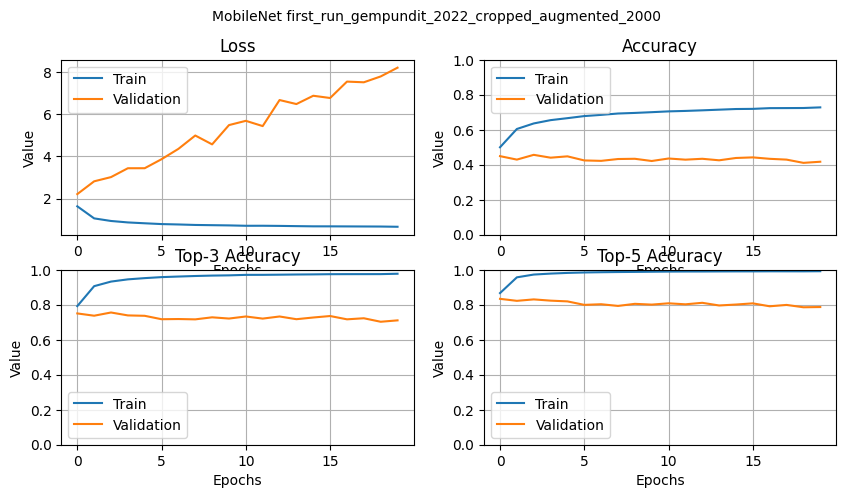

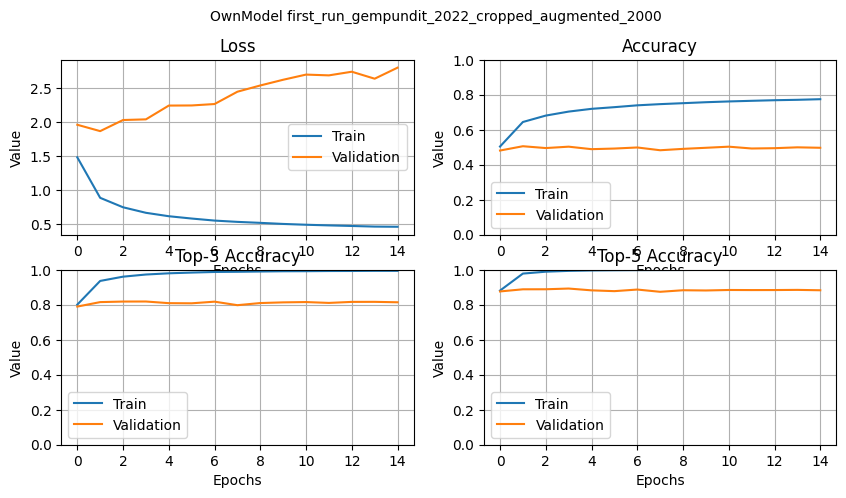

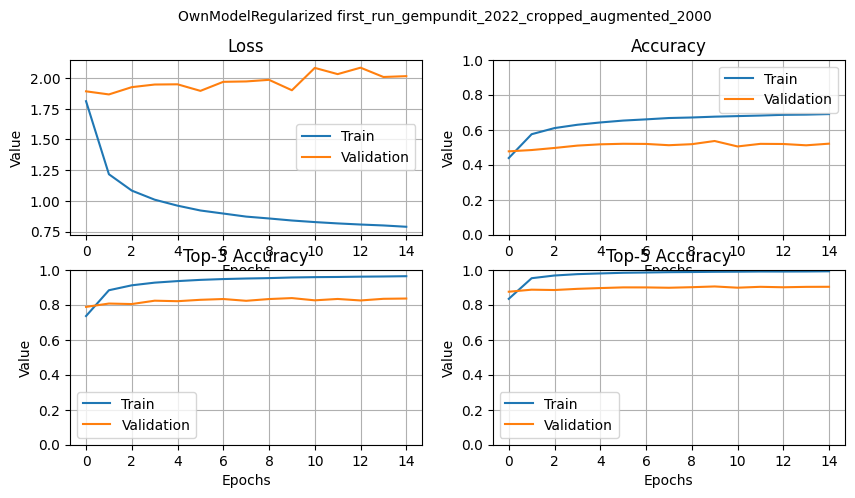

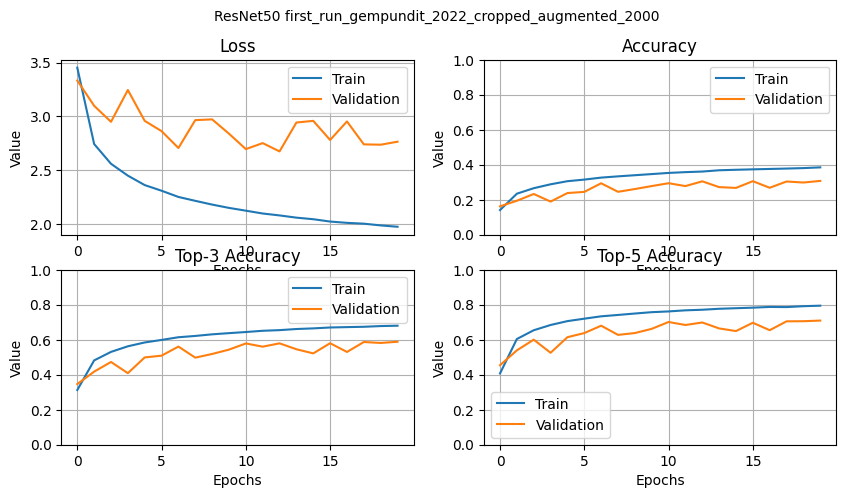

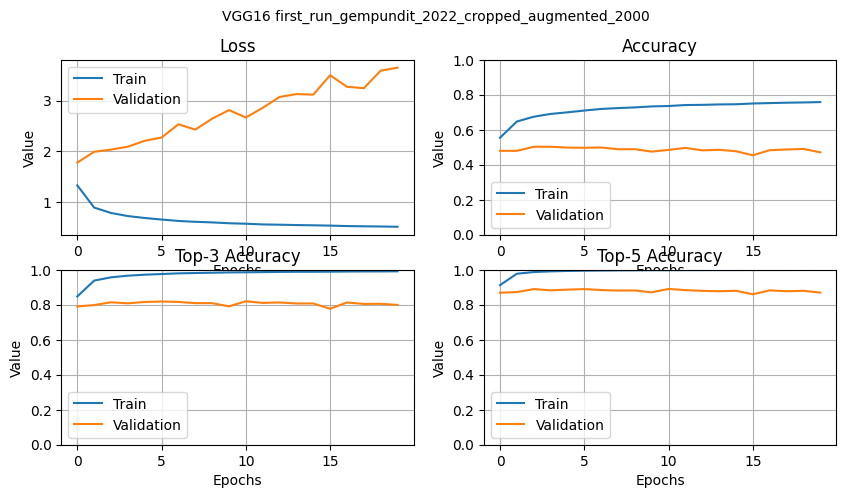

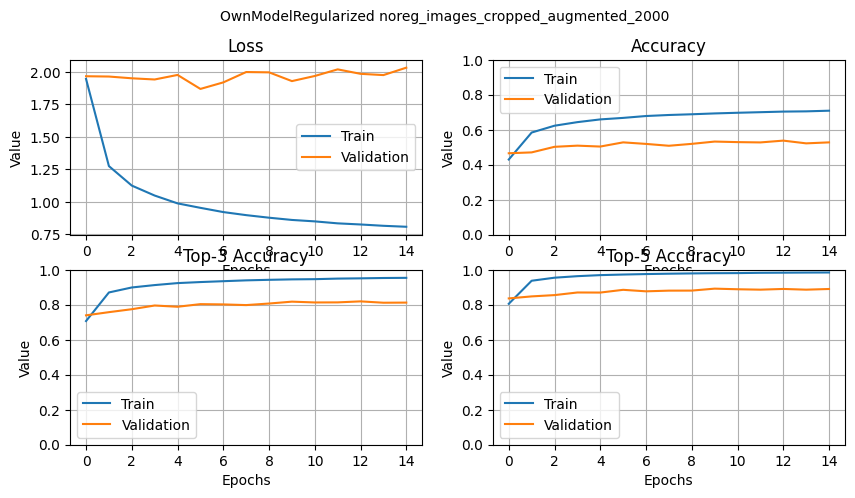

In [5]:
# Define a function to plot the metrics with adjusted y-axis limits for accuracy plots
def plot_metrics_adjusted(history, title):
    fig, axs = plt.subplots(2, 2, figsize=(10, 5))
    fig.suptitle(title, fontsize=10)

    # Loss
    axs[0, 0].plot(history['loss'], label='Train')
    axs[0, 0].plot(history['val_loss'], label='Validation')
    axs[0, 0].set_title('Loss')
    axs[0, 0].legend()

    # Accuracy
    axs[0, 1].plot(history['accuracy'], label='Train')
    axs[0, 1].plot(history['val_accuracy'], label='Validation')
    axs[0, 1].set_title('Accuracy')
    axs[0, 1].set_ylim([0, 1])
    axs[0, 1].legend()

    # Top-3 Accuracy
    axs[1, 0].plot(history['top_3_accuracy'], label='Train')
    axs[1, 0].plot(history['val_top_3_accuracy'], label='Validation')
    axs[1, 0].set_title('Top-3 Accuracy')
    axs[1, 0].set_ylim([0, 1])
    axs[1, 0].legend()

    # Top-5 Accuracy
    axs[1, 1].plot(history['top_5_accuracy'], label='Train')
    axs[1, 1].plot(history['val_top_5_accuracy'], label='Validation')
    axs[1, 1].set_title('Top-5 Accuracy')
    axs[1, 1].set_ylim([0, 1])
    axs[1, 1].legend()

    for ax in axs.flat:
        ax.set(xlabel='Epochs', ylabel='Value')
        ax.grid()

for model, history in results.items():
    plot_metrics_adjusted(history, model)


### Compare the models for the used Top-K-Accuracy

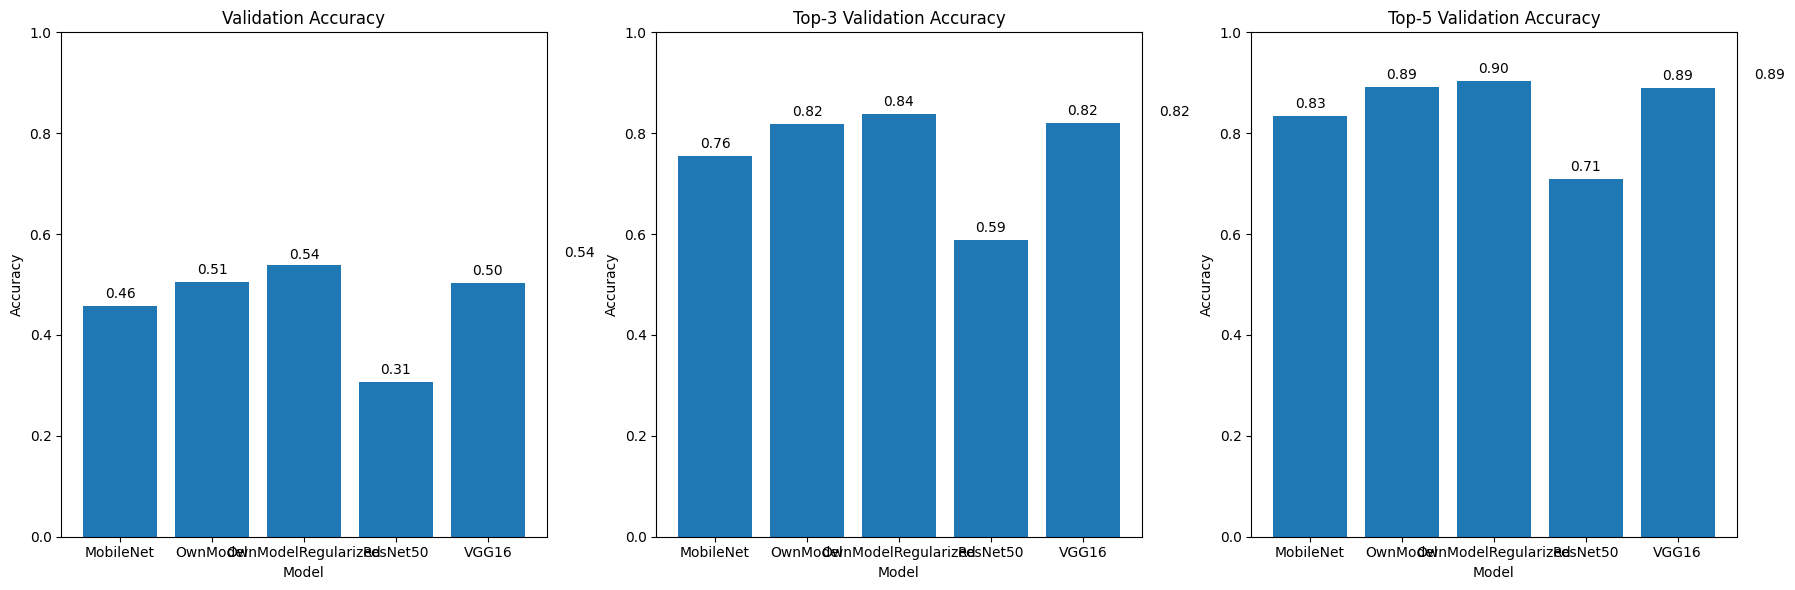

In [6]:
# Function to create bar plots for each Top-k accuracy
def create_bar_plot(y_values, title, y_label, ax):
    ax.bar(top_results['Model'], y_values)
    ax.set_title(title)
    ax.set_ylim([0, 1])
    ax.set_xlabel('Model')
    ax.set_ylabel(y_label)
    for i, v in enumerate(y_values):
        ax.text(i, v + 0.01, f"{v:.2f}", ha='center', va='bottom')

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Accuracy plot
create_bar_plot(top_results['Accuracy'], 'Validation Accuracy', 'Accuracy', axs[0])

# Top-3 Accuracy plot
create_bar_plot(top_results['Top-3 Accuracy'], 'Top-3 Validation Accuracy', 'Accuracy', axs[1])

# Top-5 Accuracy plot
create_bar_plot(top_results['Top-5 Accuracy'], 'Top-5 Validation Accuracy', 'Accuracy', axs[2])

plt.tight_layout()
plt.show()

In [7]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
import numpy as np

# Load the model
models_path = r'C:\Users\david\projects\University\gemstone-classifier\mod\first run_gempundit_2022_cropped_augmented_2000'
data_dir = r'C:\Users\david\projects\University\gemstone-classifier\dat\gempundit_2022_cropped_augmented_2000'

models = []
for file in os.listdir(os.path.normpath(models_path)):
    if file.endswith('.h5'):
        models.append(file)

# Parameters (replace these with your values)
target_size = (224, 224)  # Example target size
batch_size = 32
validation_split = 0.2

# Image data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=validation_split)

# Load data
train_data = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=False  # Important for evaluation
)

val_data = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False  # Important for evaluation
)

# Evaluate the model
val_steps = val_data.samples // batch_size

true_classes = val_data.classes
true_classes = true_classes[:val_steps * batch_size]  # Aligning the true labels length with the prediction length

index_to_class = {v: k for k, v in val_data.class_indices.items()}

results = {}
for model_name in models:
    print(f'Processing {model_name}...')
    model = load_model(models_path + '/' + model_name)

    predictions = model.predict(val_data, steps=val_steps)

    predicted_probs = predictions[:len(true_classes)]  # Aligning the prediction length with true labels
    predicted_labels = np.argmax(predicted_probs, axis=1)

    results[model_name] = {
        'predicted_probs': predicted_probs,
        'predicted_labels': predicted_labels
    }


FileNotFoundError: [WinError 3] Das System kann den angegebenen Pfad nicht finden: 'C:\\Users\\david\\projects\\University\\gemstone-classifier\\mod\\first run_gempundit_2022_cropped_augmented_2000'

### Calculate Top-K-Accuracy

In [ ]:
# Custom function to calculate top-k accuracy
def top_k_accuracy(true_labels, pred_labels, k):
    top_k_preds = np.argsort(pred_labels, axis=1)[:, -k:]
    match_array = np.any(top_k_preds == np.array(true_labels)[:, None], axis=1)
    top_k_accuracy = np.mean(match_array)
    return top_k_accuracy


top_k_acc = {}
for model, result in results.items():
    predicted_probs = result['predicted_probs']
    predicted_labels = result['predicted_labels']
    top_k_acc[model] = {}
    for k in [1, 3, 5]:
        ac = top_k_accuracy(true_classes, predicted_probs, k)
        top_k_acc[model][f'top_{k}_accuracy'] = ac

In [ ]:
print(top_k_acc)

In [ ]:
# NEW
# https://www.evidentlyai.com/classification-metrics/accuracy-precision-recall

# accuracy = (TP + TN) / (TP + TN + FP + FN) 
# precision = TP / (TP + FP) 
# 1 is always predicitng target class correctly
# recall = TP / (TP + FN)
# 1 if all instances of target found in data 

import numpy as np
import matplotlib.pyplot as plt

num_classes = np.max(true_classes) + 1  # Assuming class labels are 0-indexed
# Parameters for top-k and last-k
k = 10

for model, result in results.items():
    accuracy = []
    precision = []
    recall = []
    predicted_labels = result['predicted_labels']
    for class_id in range(num_classes):
        TP = np.sum((predicted_labels == class_id) & (true_classes == class_id))
        FP = np.sum((predicted_labels == class_id) & (true_classes != class_id))
        TN = np.sum((predicted_labels != class_id) & (true_classes != class_id))
        FN = np.sum((predicted_labels != class_id) & (true_classes == class_id))
        
        single_accuracy = (TP + TN) / (TP + TN + FP + FN)  if (TP + TN + FP + FN) > 0 else 0 
        single_precision = TP / (TP + FP) if (TP +  FP) > 0 else 0
        single_recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        
        accuracy.append(single_accuracy)
        precision.append(single_precision)
        recall.append(single_recall)
        
    accuracy_array = np.array(accuracy)
    precision_array = np.array(precision)
    recall_array = np.array(recall)

    results[model]['accuracy'] = accuracy_array
    results[model]['precision'] = precision_array
    results[model]['recall'] = recall_array

In [ ]:
# Top-K Accuracy
for i, (model, result) in enumerate(results.items()):
    top_k_indices = np.argsort(result['accuracy'])[-k:][::-1]
    top_k_ious = result['accuracy'][top_k_indices]
    top_k_class_names = [index_to_class[i] for i in top_k_indices]
    plt.figure(figsize=(5, 2))
    plt.barh(top_k_class_names, top_k_ious, color='blue')
    # show the values on the bars
    for index, value in enumerate(top_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Accuracy Score')
    plt.xlim([0, 1])
    plt.title(f'Top-{k} Classes with Highest Accuracy Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()

In [ ]:
# Least-K Accuracy
for i, (model, result) in enumerate(results.items()):
    last_k_indices = np.argsort(result['accuracy'])[:k]
    last_k_ious = result['accuracy'][last_k_indices]
    last_k_class_names = [index_to_class[i] for i in last_k_indices]

    plt.figure(figsize=(5, 2))
    plt.barh(last_k_class_names, last_k_ious, color='red')
    # show the values on the bars
    for index, value in enumerate(last_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Accuracy Score')
    plt.xlim([0, 0.5])
    plt.title(f'Bottom-{k} Classes with Lowest Accuracy Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()    

In [ ]:
for i, (model, result) in enumerate(results.items()):
    plt.figure(figsize=(5, 2))
    plt.bar(list(range(len(result['accuracy']))), result['accuracy'][np.argsort(result['accuracy'])])
    plt.xlabel('Accuracy Score')
    plt.ylim([0, 1])
    plt.title(f'Accuracy Scores for all Classes in {model}')
    plt.show()

In [ ]:
# Top-K Precision
for i, (model, result) in enumerate(results.items()):
    top_k_indices = np.argsort(result['precision'])[-k:][::-1]
    top_k_ious = result['precision'][top_k_indices]
    top_k_class_names = [index_to_class[i] for i in top_k_indices]
    plt.figure(figsize=(5, 2))
    plt.barh(top_k_class_names, top_k_ious, color='blue')
    # show the values on the bars
    for index, value in enumerate(top_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Precision Score')
    plt.xlim([0, 1])
    plt.title(f'Top-{k} Classes with Highest Precision Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()

In [ ]:
# Least-K Precision
for i, (model, result) in enumerate(results.items()):
    last_k_indices = np.argsort(result['precision'])[:k]
    last_k_ious = result['precision'][last_k_indices]
    last_k_class_names = [index_to_class[i] for i in last_k_indices]

    plt.figure(figsize=(5, 2))
    plt.barh(last_k_class_names, last_k_ious, color='red')
    # show the values on the bars
    for index, value in enumerate(last_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Precision Score')
    plt.xlim([0, 0.5])
    plt.title(f'Bottom-{k} Classes with Lowest Precision Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()    

In [ ]:
for i, (model, result) in enumerate(results.items()):
    plt.figure(figsize=(5, 2))
    plt.bar(list(range(len(result['precision']))), result['precision'][np.argsort(result['precision'])])
    plt.xlabel('Precision Score')
    plt.ylim([0, 1])
    plt.title(f'Precision Scores for all Classes in {model}')
    plt.show()

In [ ]:
# Top-K Recall
for i, (model, result) in enumerate(results.items()):
    top_k_indices = np.argsort(result['recall'])[-k:][::-1]
    top_k_ious = result['recall'][top_k_indices]
    top_k_class_names = [index_to_class[i] for i in top_k_indices]
    plt.figure(figsize=(5, 2))
    plt.barh(top_k_class_names, top_k_ious, color='blue')
    # show the values on the bars
    for index, value in enumerate(top_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Recall Score')
    plt.xlim([0, 1])
    plt.title(f'Top-{k} Classes with Highest Recall Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()

In [ ]:
# Least-K Recall
for i, (model, result) in enumerate(results.items()):
    last_k_indices = np.argsort(result['recall'])[:k]
    last_k_ious = result['recall'][last_k_indices]
    last_k_class_names = [index_to_class[i] for i in last_k_indices]

    plt.figure(figsize=(5, 2))
    plt.barh(last_k_class_names, last_k_ious, color='red')
    # show the values on the bars
    for index, value in enumerate(last_k_ious):
        plt.text(value, index, f'{value:.2f}', ha='left', size=10)
    plt.xlabel('Recall Score')
    plt.xlim([0, 0.5])
    plt.title(f'Bottom-{k} Classes with Lowest Recall Scores for {model}')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest value on top
    plt.show()    

In [ ]:
for i, (model, result) in enumerate(results.items()):
    plt.figure(figsize=(5, 2))
    plt.bar(list(range(len(result['recall']))), result['recall'][np.argsort(result['recall'])])
    plt.xlabel('Recall Score')
    plt.ylim([0, 1])
    plt.title(f'Recall Scores for all Classes in {model}')
    plt.show()

### What was misclassified as what?

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

data_path = r'C:\Users\david\projects\University\gemstone-classifier\dat\gempundit_2022'
predicted_labels = results['OwnModelRegularized.h5']['predicted_labels']
last_k_indices = np.argsort(results['OwnModelRegularized.h5']['ious'])[:k]

# Calculate the confusion matrix
cm = confusion_matrix(true_classes, predicted_labels)


for class_id in last_k_indices:
    class_row = cm[class_id, :].copy()
    class_row[class_id] = 0  # Zero out the diagonal
    
    number_of_misclassifications = np.sum(class_row)
    
    # Most common misclassification
    most_common_misclassified_as = np.argmax(class_row)
    most_common_count = class_row[most_common_misclassified_as]
    most_common_percentage_misclassified = round(most_common_count / number_of_misclassifications * 100, 1)
    
    # Second most common misclassification
    class_row[most_common_misclassified_as] = 0  # Zero out the most common
    second_most_common_misclassified_as = np.argmax(class_row)
    second_most_common_count = class_row[second_most_common_misclassified_as]
    second_most_common_percentage_misclassified = round(second_most_common_count / number_of_misclassifications * 100, 1)
    
    image_count = len(os.listdir(os.path.join(data_path, index_to_class[class_id])))
    
    # Print results
    print(f"Class '{index_to_class[class_id]}' misclassified {most_common_percentage_misclassified}% as '{index_to_class[most_common_misclassified_as]}' and {second_most_common_percentage_misclassified}% as '{index_to_class[second_most_common_misclassified_as]}'.")